In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score

from mlxtend.preprocessing import MeanCenterer

import seaborn as sns
import matplotlib.pyplot as plt

In [142]:
# Read .txt file as pandas dataframe
data = pd.read_csv('crabs.txt', delimiter=" ")
print(data.shape)
data.head()

(200, 7)


,FL,RW,CL,CW,BD,sp,sex
0,8.1,6.7,16.1,19.0,7.0,B,M
1,8.8,7.7,18.1,20.8,7.4,B,M
2,9.2,7.8,19.0,22.4,7.7,B,M
3,9.6,7.9,20.1,23.1,8.2,B,M
4,9.8,8.0,20.3,23.0,8.2,B,M


In [143]:
# Combine species and sex into 4 classes
data['y'] = data['sp'] + data['sex']
feature_list = data.columns[:-3]
X,y = data[feature_list].to_numpy(),data['y'].to_numpy()

#First sample
X[0],y[0]

(array([ 8.1,  6.7, 16.1, 19. ,  7. ]), 'BM')

In [144]:
#Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)#, stratify = y)

### Exercise 1

#### A) Perform PCA on training data via an eigendecomposition 

In [145]:
# Mean centering ensures data is centered around the origin. Prevent data shift

mc = MeanCenterer().fit(X_train)
X_train = mc.transform(X_train)
X_test = mc.transform(X_test)

In [128]:
cov_mat = np.cov(X_train.T) # denoted as S in slides
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Eigenvalues in decresing order
order = np.argsort(eigen_vals)[::-1]

sort_eigen_vals = eigen_vals[order]
sort_eigen_vecs = eigen_vecs[:, order]

for i in range(X_train.shape[1]):
    print('Eigenvalue {}: {:.4f}'.format(i+1, sort_eigen_vals[i]))
    print(f'PC {i+1} loading vector {sort_eigen_vecs[:,i]}')

# Print the percentage of variance explained by each component
explained_variance_ratio = sort_eigen_vals / np.sum(sort_eigen_vals)
print("\nPercentage of variance explained by each component:")
for i, var_ratio in enumerate(explained_variance_ratio):
    print(f'PC {i+1}: {var_ratio * 100:.2f}%')

Eigenvalue 1: 147.8025
PC 1 loading vector [0.28797987 0.19738777 0.59935705 0.661853   0.2843016 ]
Eigenvalue 2: 1.2973
PC 2 loading vector [ 0.34414595  0.83931757 -0.1865451  -0.31817985  0.2026625 ]
Eigenvalue 3: 1.0284
PC 3 loading vector [-0.48231117  0.46588277 -0.18667469  0.47226163 -0.54078711]
Eigenvalue 4: 0.1289
PC 4 loading vector [ 0.74880604 -0.1487546  -0.19401891  0.15082214 -0.59730305]
Eigenvalue 5: 0.0755
PC 5 loading vector [ 0.07277783 -0.13194469 -0.73039803  0.46360956  0.47841288]

Percentage of variance explained by each component:
PC 1: 98.32%
PC 2: 0.86%
PC 3: 0.68%
PC 4: 0.09%
PC 5: 0.05%


In [130]:
#Transform features with dot product 
pcs = X_train @ sort_eigen_vecs
print(pcs.shape)
print(pcs[0])


(180, 5)
[-1.76046565  0.23884416 -2.05363538  0.19548688 -0.21957919]


#### B) PCA via sklearn

In [132]:
pca = PCA()

# With sklearn PCA, it automatically centers the data
pca.fit(X_train)

# Eigenvalues, PC scores and variance explained
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_ * 100
scores = pca.transform(X_train)

print("Eigenvalues:", eigenvalues)
print('Eigenvctors: ', eigenvectors)
print("\nPercentage of variance explained by each PC:")
for i, variance in enumerate(explained_variance_ratio):
    print(f'PC {i+1}: {variance:.2f}%')

Eigenvalues: [1.47802482e+02 1.29730456e+00 1.02835151e+00 1.28918770e-01
 7.54894832e-02]
Eigenvctors:  [[-0.28797987 -0.19738777 -0.59935705 -0.661853   -0.2843016 ]
 [-0.34414595 -0.83931757  0.1865451   0.31817985 -0.2026625 ]
 [-0.48231117  0.46588277 -0.18667469  0.47226163 -0.54078711]
 [ 0.74880604 -0.1487546  -0.19401891  0.15082214 -0.59730305]
 [-0.07277783  0.13194469  0.73039803 -0.46360956 -0.47841288]]

Percentage of variance explained by each PC:
PC 1: 98.32%
PC 2: 0.86%
PC 3: 0.68%
PC 4: 0.09%
PC 5: 0.05%


### Exercise 2

Make two scatterplot matrices (plot of pairs of features against each other) – one for the
raw training data and one for the principal components – where observations are colored by class

/Users/florentinafabregas/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x800 with 0 Axes>

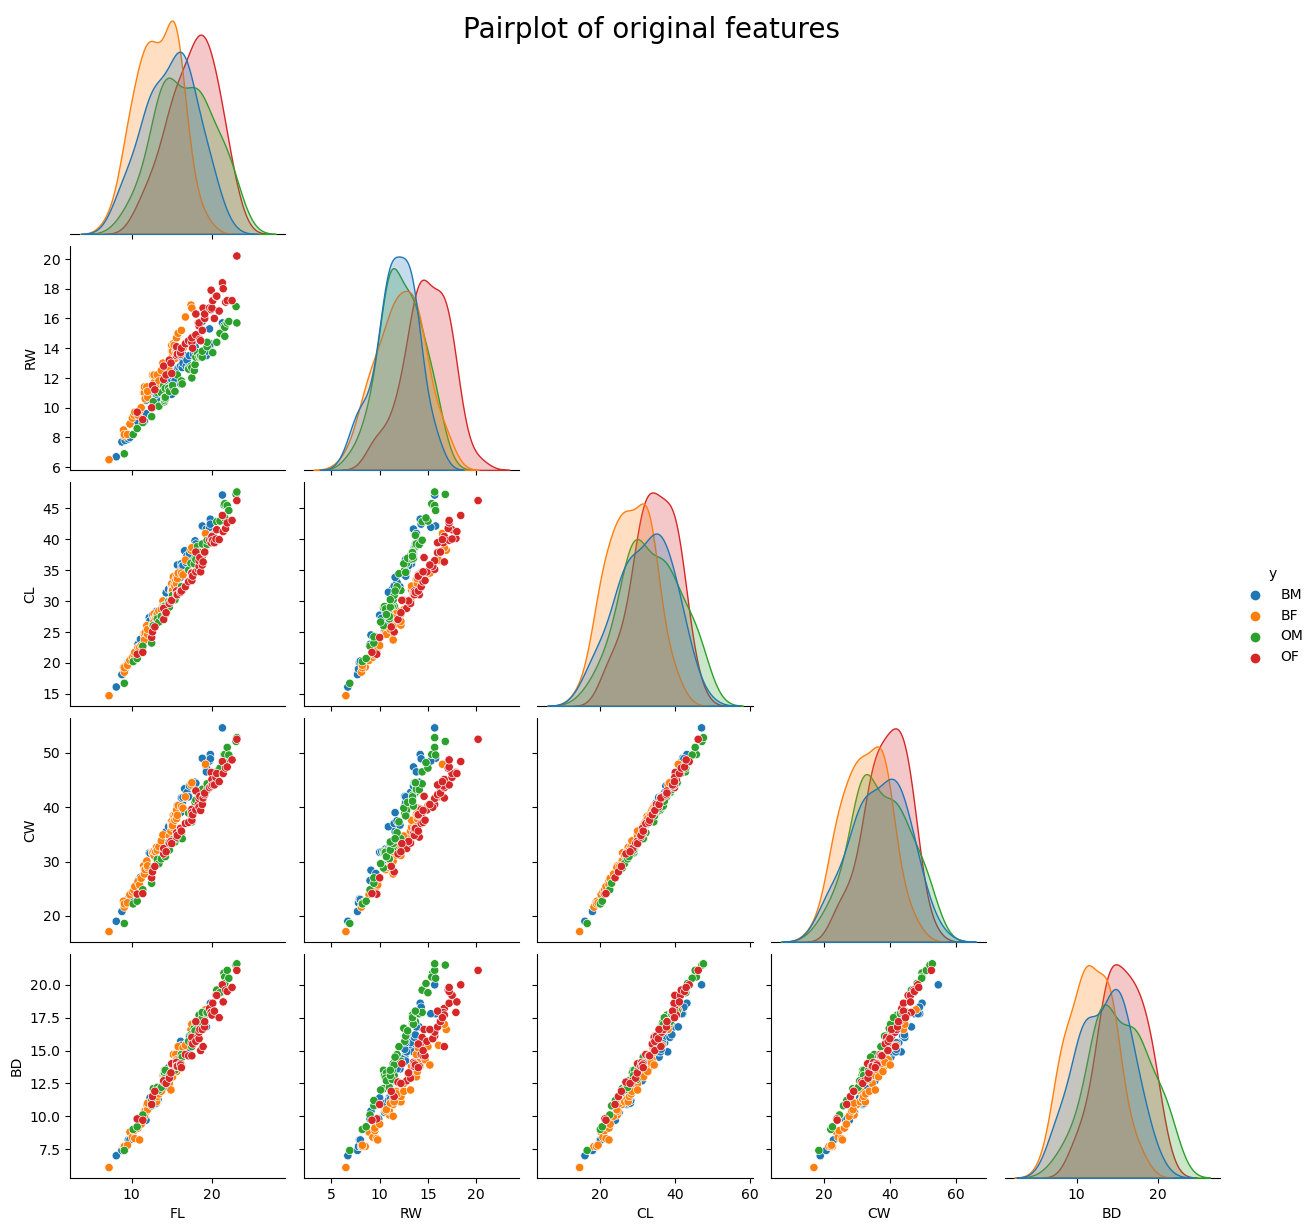

In [146]:
# Scatterplot for original features
plt.figure(figsize=(8,8));
sns.pairplot(data=data, hue='y', corner=True);
plt.suptitle('Pairplot of original features', fontsize=20)
plt.show();

/Users/florentinafabregas/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x800 with 0 Axes>

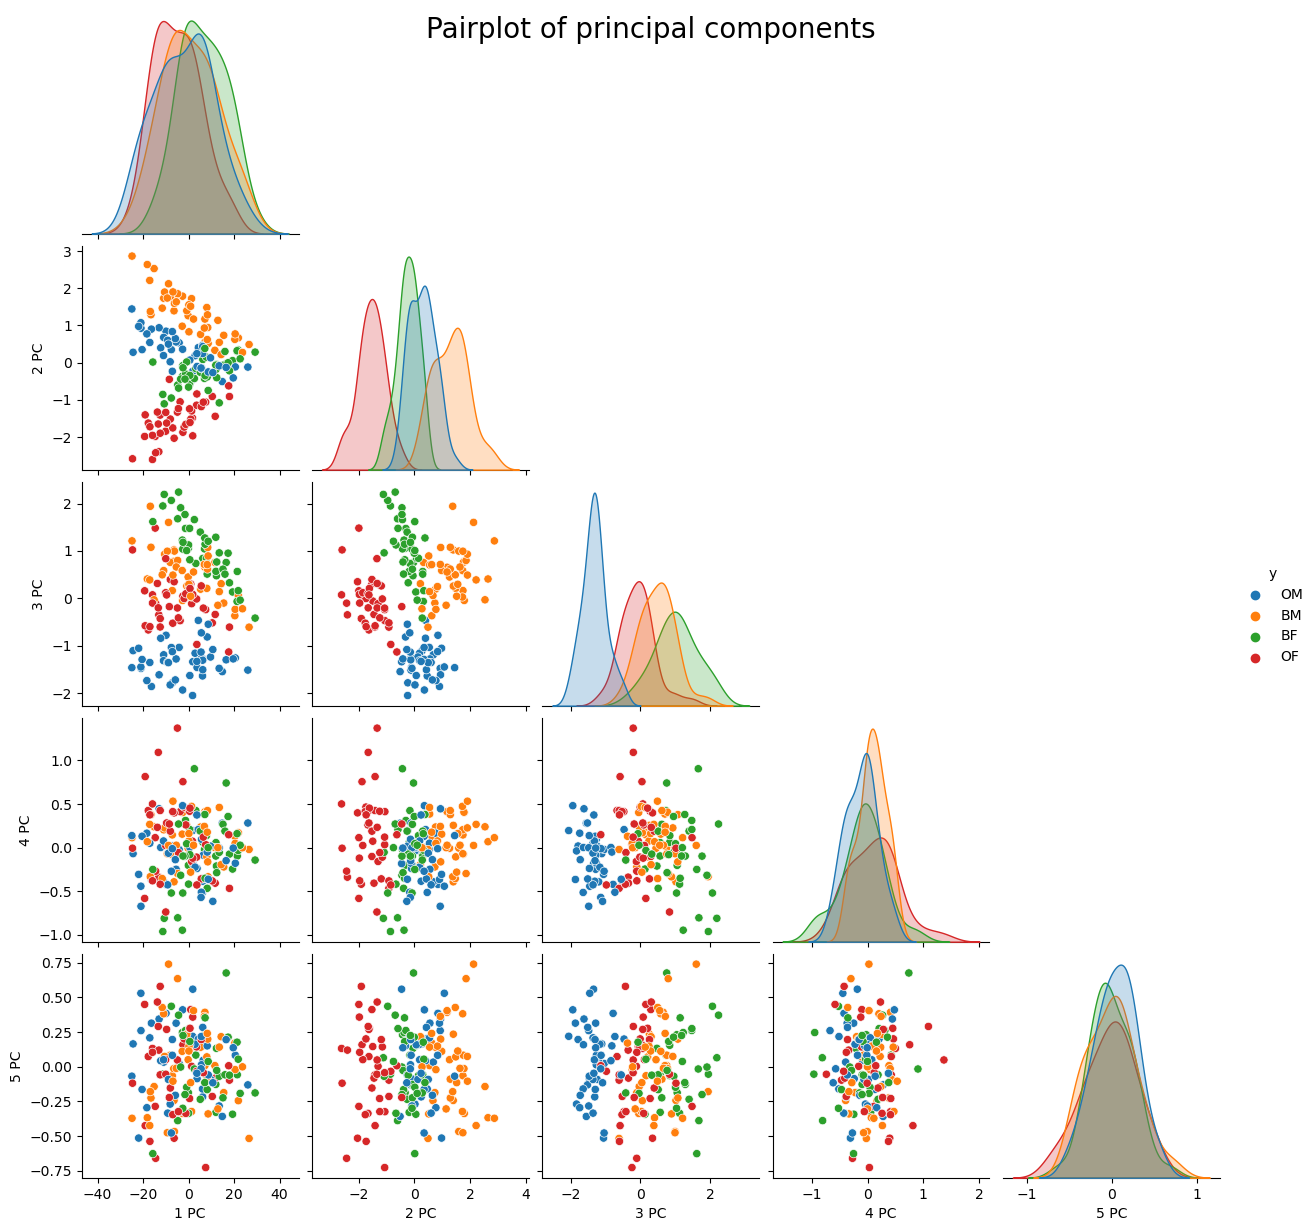

In [147]:
# Scatterplot of the principal components
column_names = [f'{i+1} PC' for i in range(scores.shape[1])] + ['y']
data_pca = np.append(scores, y_train.reshape(-1, 1), axis=1)
pca_df = pd.DataFrame(data_pca, columns=column_names)

plt.figure(figsize=(8,8))
sns.pairplot(data=pca_df, hue='y', corner=True);
plt.suptitle('Pairplot of principal components', fontsize=20)
plt.show();

Much more separability in the classes when using principal components

### Exercise 3 

Find the loadings of the first principal component and explain what they are and how to
use them for interpreting the principal component.

In [137]:
loadings_non_std = pca.components_
print('Loading first component:')
print(loadings_non_std[0])

Loading first component:
[-0.28797987 -0.19738777 -0.59935705 -0.661853   -0.2843016 ]


The vector of loadings is the eigenvector, in this case, associated to the largest eigenvalue. For any specific data point, if we multiply the loading vector by its original features values, we obtain the projection of that data point onto the first PC. Each element of the loading vector indicates how much weight each original feature has in the PC. 

### Exercise 4

Find the variances of the principal components and make three plots
1. Variance against component number
2. Proportion variance explained against component number
3. Cumulative sum of variances for the first k components against component number k.

Discuss how the plots can be used to inform the choice of how many principal components to use in
further analyses.


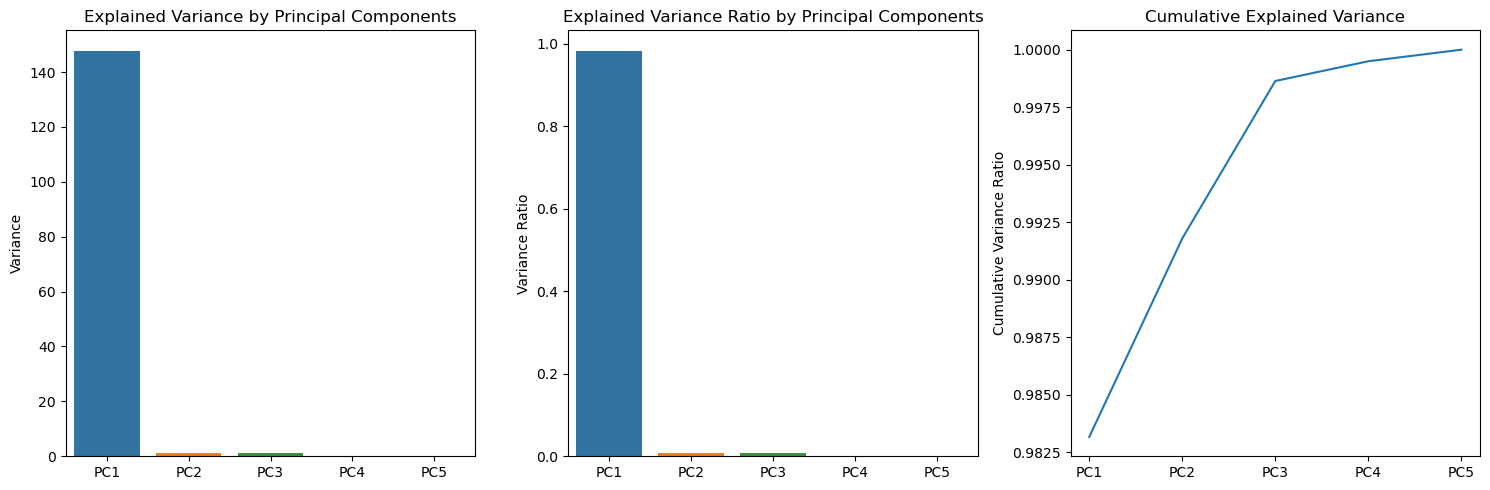

In [95]:
components = [f'PC{i+1}' for i in range(pcs.shape[1])]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(x=components, y=pca.explained_variance_, ax=axes[0])
axes[0].set_title('Explained Variance by Principal Components')
axes[0].set_ylabel('Variance')

sns.barplot(x=components, y=pca.explained_variance_ratio_, ax=axes[1])
axes[1].set_title('Explained Variance Ratio by Principal Components')
axes[1].set_ylabel('Variance Ratio')

sns.lineplot(x=components, y=np.cumsum(pca.explained_variance_ratio_), ax=axes[2])
axes[2].set_title('Cumulative Explained Variance')
axes[2].set_ylabel('Cumulative Variance Ratio')

plt.tight_layout()
plt.show()


Choose number of components that explain most of the variance. 

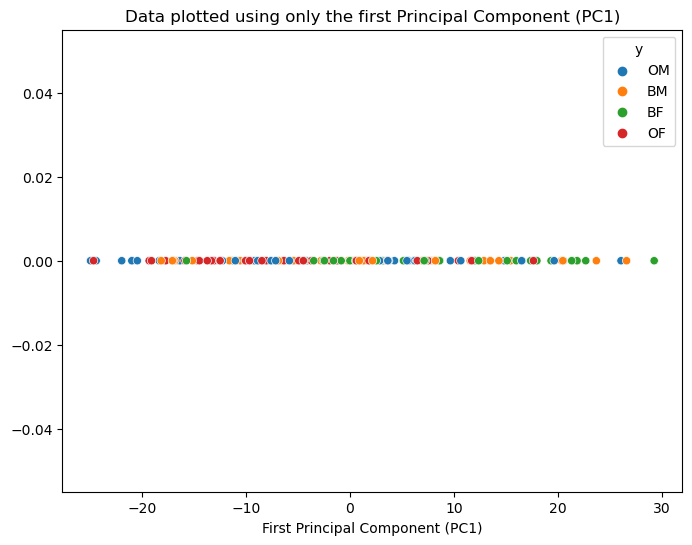

In [69]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['1 PC'], y=[0]*len(pca_df), hue=pca_df['y'])
plt.xlabel('First Principal Component (PC1)')
plt.title('Data plotted using only the first Principal Component (PC1)')
plt.show()

First PC explains 99% of variance but provides no separability between classes. Maybe not a good option. We can already see this in the paiplot. In next section we determine the number of PC (K) by cross validation. 

### Exercise 5 

Train a 5-nearest neighbours classifier based on the first two principal components.

In [70]:
X_train_pc2 = pca_df[['1 PC','2 PC']]
knn5 = KNN(5).fit(X_train_pc2, y_train)

### Exercise 6 

Compute the test error for your 5-nn classifier. Remember that you need to apply the PCA
transformation obtained from the training data to the test data – do not perform a new PCA on the test
data

In [71]:
# Apply PCA on test and save in df
test_scores = pca.transform(X_test)
test_pca_df = pd.DataFrame(test_scores)
test_pca_df['y'] = y_test
test_pca_df.columns = column_names

In [72]:
# Compute test error
def test_error(clf, y_test, X_test):
    error = 1 - accuracy_score(y_test, clf.predict(X_test))
    return round(error,4)

In [73]:
print('Test error 5-NN: ', test_error(knn5,y_test, test_pca_df[['1 PC','2 PC']]))

Test error 5-NN:  0.3


In [74]:
# Perform cross-validation to select K - optimal number of PC..
metrics = []

for i in range(1,X_train.shape[1]):
    X_train_pc_n = data_pca[:, :i]

    knn = KNN(5)
    acc = cross_val_score(knn, X_train_pc_n, y_train, cv=5, scoring='accuracy')
    metrics.append(np.mean(acc))

optimal_k = np.argmax(metrics) +1
print('Optimal K: ', optimal_k)

Optimal K:  3


In [75]:
# Test error for 5-NN with 3 PC
knn5_3pc = KNN(5).fit(pca_df[['1 PC','2 PC', '3 PC']], y_train)
print('Test error 5-nn - 3 PC: ', test_error(knn5_3pc ,y_test, test_pca_df[['1 PC','2 PC', '3 PC']]))


Test error 5-nn - 3 PC:  0.1


/Users/florentinafabregas/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

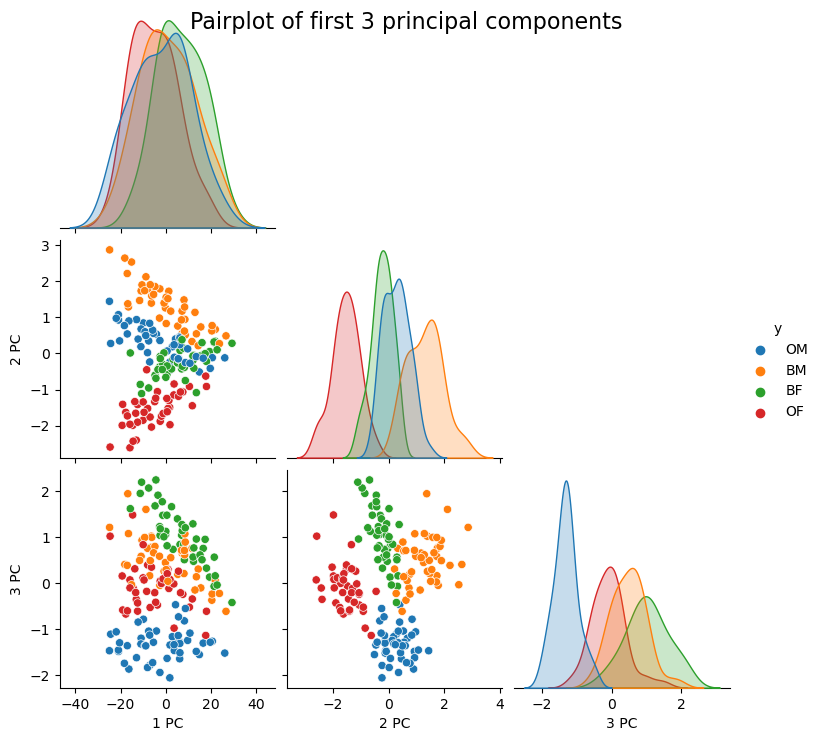

In [76]:
plt.figure()
sns.pairplot(data=pca_df[['1 PC','2 PC', '3 PC', 'y']], hue='y', corner=True)
plt.suptitle('Pairplot of first 3 principal components', fontsize=16)
plt.show();

### Exercise 7 

Perform another PCA, this time where you first standardise each feature to have mean 0
and variance 1. Explain why standardising variables can be a good idea.

In [138]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

pca = PCA()
X_train_std_pca = pca.fit_transform(X_train_std)
X_test_std_pca = pca.fit_transform(X_test_std)
loadings_std = pca.components_

train_std_pca_ = np.append(X_train_std_pca, y_train.reshape(-1, 1), axis=1)
train_std_df= pd.DataFrame(train_std_pca_, columns=column_names)

test_std_pca_ = np.append(X_test_std_pca, y_test.reshape(-1, 1), axis=1)
test_std_df = pd.DataFrame(test_std_pca_, columns=column_names)

print(train_std_df.shape)
print(test_std_df.shape)

(180, 6)
(20, 6)


/Users/florentinafabregas/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x800 with 0 Axes>

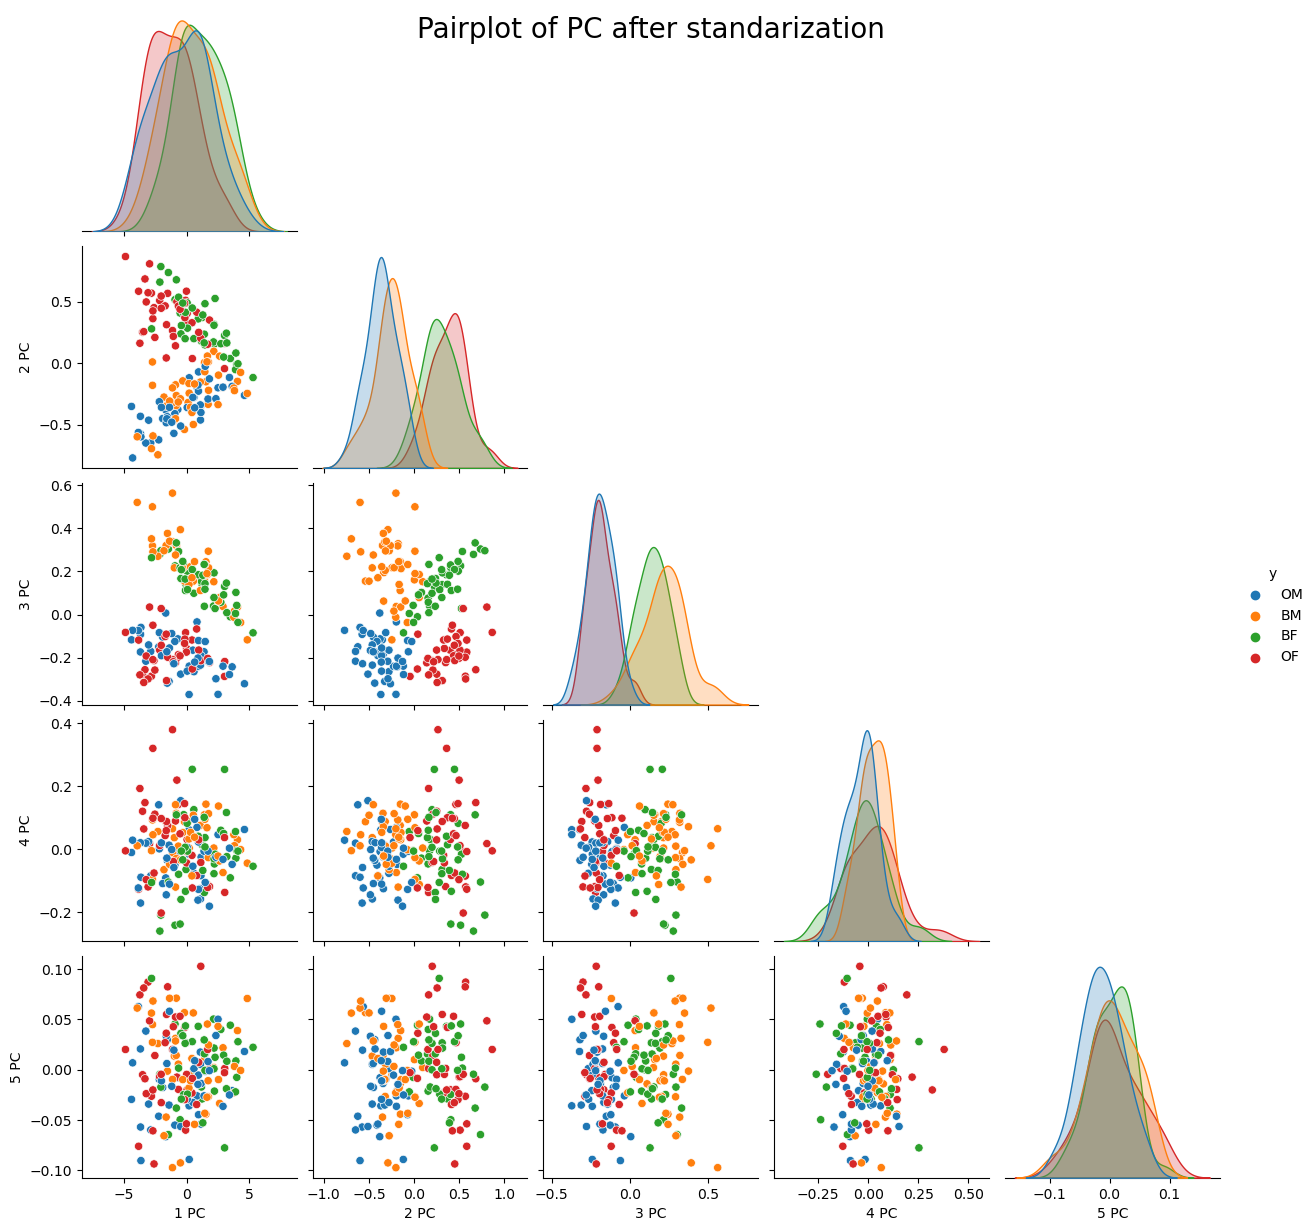

In [112]:
plt.figure(figsize=(8,8));
sns.pairplot(data=train_std_df, hue='y', corner=True);
plt.suptitle('Pairplot of PC after standarization', fontsize=20)
plt.show();

It is very important to standarize because PCA is sensitive to the scale of the features. If a feature have larger scale, it will dominate the PCs. By standarizing we make sure each feature contributes equally to variance, allowing PCA to properly capture the underlying structure of the data.

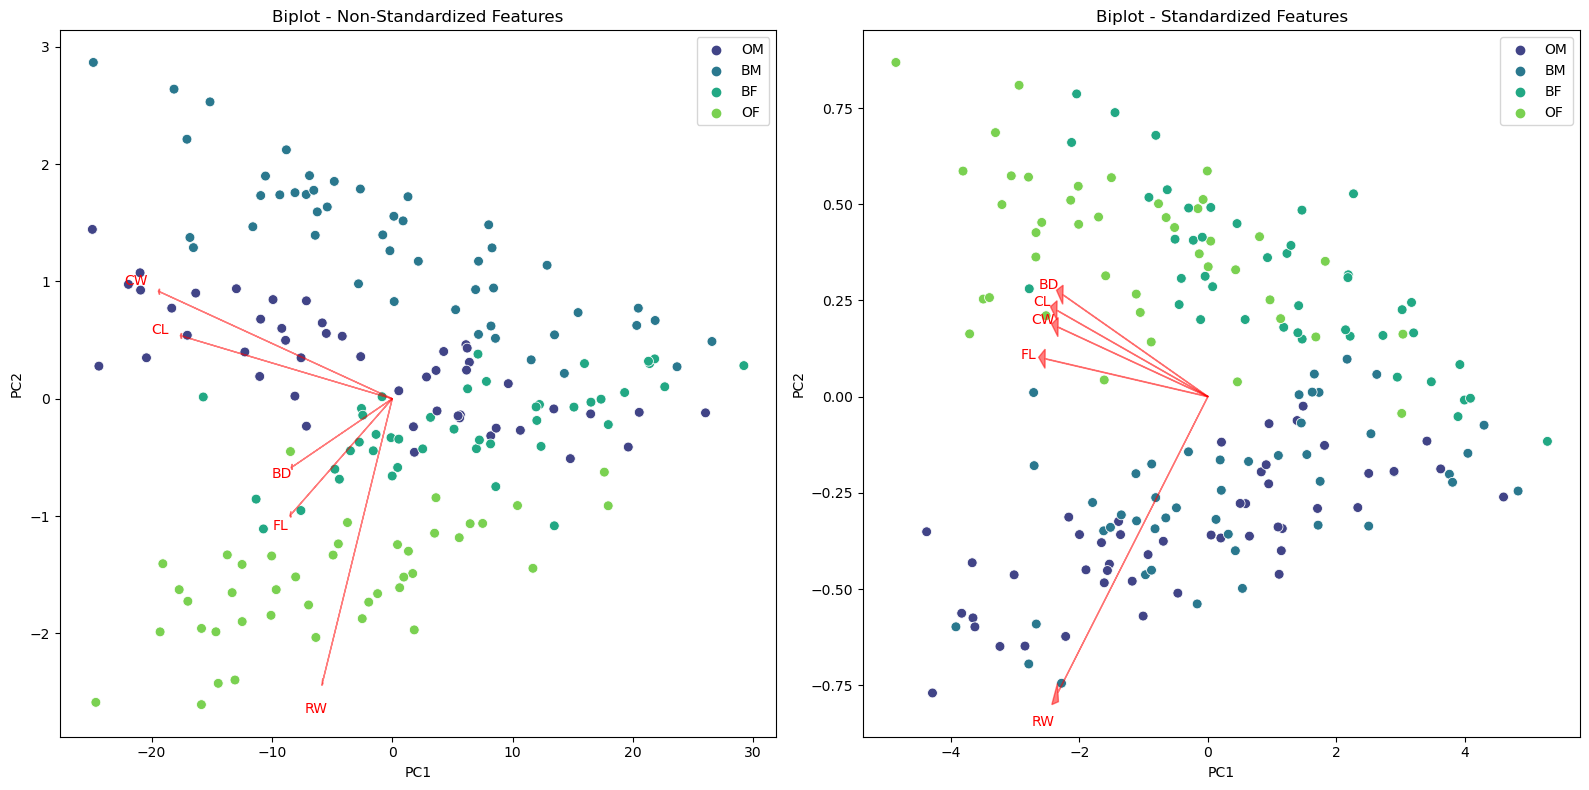

In [139]:
features = list(data.columns[:5])

# Create subplots: one row, two columns
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Biplot for non-standardized data
sns.scatterplot(x=pca_df['1 PC'], y=pca_df['2 PC'], hue=y_train, palette='viridis', ax=axes[0], s=50)
axes[0].set_title('Biplot - Non-Standardized Features')
axes[0].set_xlabel(f'PC1')
axes[0].set_ylabel(f'PC2')

# Add arrows for loadings (non-standardized data)
loadings_nonstd = loadings_non_std.T
for i, feature in enumerate(features):
    axes[0].arrow(0, 0, loadings_nonstd[i, 0] * max(pca_df['1 PC']), loadings_nonstd[i, 1] * max(pca_df['2 PC']), 
                  color='r', alpha=0.5, head_width=0.05, head_length=0.1)
    axes[0].text(loadings_nonstd[i, 0] * max(pca_df['1 PC']) * 1.1, 
                 loadings_nonstd[i, 1] * max(pca_df['2 PC']) * 1.1, 
                 feature, color='r', ha='center', va='center')

# Biplot for standardized data
sns.scatterplot(x=train_std_df['1 PC'], y=train_std_df['2 PC'], hue=y_train, palette='viridis', ax=axes[1], s=50)
axes[1].set_title('Biplot - Standardized Features')
axes[1].set_xlabel(f'PC1')
axes[1].set_ylabel(f'PC2')

# Add arrows for loadings (standardized data)
loadings_std = loadings_std.T
for i, feature in enumerate(features):
    axes[1].arrow(0, 0, loadings_std[i, 0] * max(train_std_df['1 PC']), loadings_std[i, 1] * max(train_std_df['2 PC']), 
                  color='r', alpha=0.5, head_width=0.05, head_length=0.1)
    axes[1].text(loadings_std[i, 0] * max(train_std_df['1 PC']) * 1.1, 
                 loadings_std[i, 1] * max(train_std_df['2 PC']) * 1.1, 
                 feature, color='r', ha='center', va='center')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


### Exercise 8

Sphere the training data by first applying PCA and then scaling each principal component
by its standard deviation. The result is data where not only features are uncorrelated, but they also
have unit variance. Plot the sphered data in a scatterplot matrix or similar to see the effect of the
transformation.
Sphering – also referred to as whitening – can be done directly in sklearn by specifying whiten = True
in the call to PCA. Sphering can be used as a preprocessing step before applying other machine learning
methods, such as knn.


In [140]:
# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# PCA with whitening (= sphering). Scales each PC to have variance 1.
pca = PCA(whiten=True)
X_train_sph = pca.fit_transform(X_train_scaled)
X_test_sph = pca.fit_transform(X_test_scaled)

# Dataframe for train and test
df_sphere = pd.DataFrame(X_train_sph)
df_sphere['y'] = y_train
df_sphere.columns = column_names

df_test_sphere = pd.DataFrame(X_test_sph)
df_test_sphere['y'] = y_test
df_test_sphere.columns = column_names

Sphering ensures all features contribute equally by having unit variance. No feature dominates for having large variance. 

In [ ]:
sns.pairplot(df_sphere, hue='y', corner=True)
plt.suptitle("Sphered (Whitened) Data")
plt.show()